# Red Neuronal Artificial para clasificación de íconos

## Integrantes: Carlos Morocho, Wilson Rodas

### 1. Importación de las librerías necesarias

In [1]:
#Librerias base
import os
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as pp
from itertools import repeat

#Librerias para redes neuronales
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy

#Librerias para tratamiento de datos
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Librerias para reportes
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import A3

%matplotlib inline

### 2. Carga del corpus de datos

In [2]:
#Usamos numpy para cargar los datos
iconos = np.load('./Iconos.npy', allow_pickle = True).item()
print('Este corpus cuenta con un total de', len(iconos['image']),'muestras.')

#Dividimos la muestras en entradas y salidas
datos_entrada = iconos['image']
datos_salida = iconos['class']

Este corpus cuenta con un total de 10000 muestras.


### 3. Asignación de etiquetas de las categorías

In [3]:
#Cargamos las categorías en orden alfabético
lista_categorias = os.listdir('./Iconos')
lista_categorias.sort(key = str.lower)

#Visualizamos las categorías de mejor manera mediante un Dataframe
categorias = pd.DataFrame(lista_categorias)
categorias

,0
0,airplane
1,arrow_directions
2,ball
3,biking
4,bird
5,blade
6,boat
7,books
8,building
9,bunny_ears


### 4. Preprocesamiento de los datos  

Ya que la dimensión de los datos de cada ícono son de (3, 32, 32), en total tenemos 3072 columnas por cada ícono. Para facilitar el trabajo convertimos los datos de la variable "x" a un DataFrame.

In [4]:
#Total de columnas deseadas
TOTAL_COLUMNAS = 3072

#Convertimos la dimensión de las muestras de 3D a 1D
datos_entrada = np.array(list(map(lambda m: m.reshape(1, -1), datos_entrada)))
datos_entrada = np.array(list(map(lambda m: m.reshape(TOTAL_COLUMNAS), datos_entrada)))

#Convertimos los datos a dataframe para mayor comodidad
datos_entrada = pd.DataFrame(datos_entrada)
datos_entrada

,0,1,2,3,4,5,6,7,8,9,...,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071
0,255,255,255,255,255,255,255,255,255,255,...,221,220,221,220,221,221,221,221,221,232
1,255,255,255,255,254,242,222,217,222,242,...,244,226,218,226,245,254,255,255,255,255
2,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
3,255,255,255,255,255,255,255,255,252,248,...,255,255,255,255,255,255,255,255,255,255
4,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,255,255,253,236,215,207,204,199,195,192,...,254,255,255,255,255,255,255,255,255,255
9996,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
9997,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
9998,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255


### 5. Generando datos de prueba aleatorios

In [5]:
#Generamos los datos de prueba de forma aleatoria usando aproximadamente el 30% del total de las muestras
filtro = np.random.rand(len(datos_entrada)) < 0.2
datos_prueba_a = datos_entrada[filtro]

datos_salida = np.array([datos_salida]).reshape(-1, 1)
datos_prueba_b = datos_salida[filtro]
datos_prueba_a.insert(3072, 3072,datos_prueba_b)

#Guardamos los datos de prueba en un archivo CSV
datos_prueba_a.to_csv('imagenes-prueba.data', sep = ',', index = False)

print('Archivo de "imagenes-prueba.data" generado con éxito.')

Archivo de "imagenes-prueba.data" generado con éxito.


### 6. División de las muestras en datos de entrenamiento y de prueba

In [32]:
#Obtenemos las muestras para entrenamiento y pruebas
x_entrenamiento, x_prueba, y_entrenamiento, y_prueba = train_test_split(
    datos_entrada, datos_salida,
    test_size = 0.3, stratify = iconos['class'],
    random_state = 251
)

print('Datos de entrenamiento y prueba generados.')

Datos de entrenamiento y prueba generados.


### 7. Conversión de "y" a un arreglo NumPy

En el conjunto de datos proporcionados nuestras salidas deseadas vienen en formato de tuplas, por ello es necesario convertirlas a un arreglo de NumPy con dimensiones (3000, 1).

In [33]:
#Convertimos las salidas de entrenamiento en arreglos
y_entrenamiento = np.array(y_entrenamiento)

#Convertimos las salidas de pruebas en arreglos
y_prueba = np.array(y_prueba)

### 8. Normalización de los datos

In [34]:
#Escalamos los datos mediante la estrategia estandar
escalador = StandardScaler()
x_entrenamiento = escalador.fit_transform(x_entrenamiento)
x_prueba = escalador.fit_transform(x_prueba)

print('Los datos de entrada han sido normalizados.')

Los datos de entrada han sido normalizados.


### 9. Creación de modelos de Redes Neuronales Artificiales

In [35]:
#Primera propuesta de red neuronal artificial (Pésima)
modelo1 = Sequential()
modelo1.add(Dense(50, activation = 'relu', input_shape = (3072, )))
modelo1.add(Dense(50, activation = 'relu'))
modelo1.add(Dense(50, activation = 'relu'))

#Segunda propuesta de red neuronal artificial (Muy malo)
modelo2 = Sequential()
modelo2.add(Dense(135, activation = 'sigmoid', input_shape = (3072, )))
modelo2.add(Dense(140, activation = 'sigmoid'))
modelo2.add(Dense(50, activation = 'sigmoid'))

#Tercera propuesta de red neuronal artificial (Pésima)
modelo3 = Sequential()
modelo3.add(Dense(150, activation = 'exponential', input_shape = (3072, )))
modelo3.add(Dense(80, activation = 'exponential'))
modelo3.add(Dense(50, activation = 'exponential'))

#Cuarta propuesta de red neuronal artificial (Muy buena)
modelo4 = Sequential()
modelo4.add(Dense(64, activation = 'relu', input_shape = (3072, )))
modelo4.add(Dense(64, activation = 'relu'))
modelo4.add(Dense(64, activation = 'relu'))
modelo4.add(Dense(50, activation = 'sigmoid'))

### 10. Definición de la función para entrenar los modelos

In [36]:
#Creación de una funcion para facilitar el entrenamiento de los modelos
def entrenar_modelo(modelo, x_entrenamiento, y_entrenamiento, x_prueba, y_prueba):
    modelo.compile(
        loss = 'sparse_categorical_crossentropy', 
        optimizer = 'sgd', 
        metrics = ['accuracy']
    )
    historial = modelo.fit(
        x_entrenamiento,
        y_entrenamiento,
        validation_data = (x_prueba, y_prueba),
        epochs = 50, 
        batch_size = 140,
        verbose = 1
    )
    return (modelo, historial)

### 11.1 Entrenamiento de los modelos (Modelo 1)

In [37]:
#Entrenamiento del modelo 1
modelo1_entrenado, historial1 = entrenar_modelo(modelo1, x_entrenamiento, y_entrenamiento, x_prueba, y_prueba)

Epoch 1/50
50/50 [==============================] - 2s 38ms/step - loss: 10.7050 - accuracy: 0.0087 - val_loss: 10.6375 - val_accuracy: 0.0083
Epoch 2/50
50/50 [==============================] - 1s 26ms/step - loss: 10.2600 - accuracy: 0.0084 - val_loss: 9.3873 - val_accuracy: 0.0083
Epoch 3/50
50/50 [==============================] - 1s 26ms/step - loss: 9.5362 - accuracy: 0.0084 - val_loss: 9.3511 - val_accuracy: 0.0083
Epoch 4/50
50/50 [==============================] - 1s 26ms/step - loss: 9.3093 - accuracy: 0.0084 - val_loss: 8.7197 - val_accuracy: 0.0083
Epoch 5/50
50/50 [==============================] - 1s 27ms/step - loss: 8.7949 - accuracy: 0.0084 - val_loss: 8.6695 - val_accuracy: 0.0083
Epoch 6/50
50/50 [==============================] - 1s 26ms/step - loss: 8.7536 - accuracy: 0.0084 - val_loss: 8.5814 - val_accuracy: 0.0083
Epoch 7/50
50/50 [==============================] - 1s 27ms/step - loss: 8.4746 - accuracy: 0.0084 - val_loss: 8.3243 - val_accuracy: 0.0083
Epoch 8/50

### 11.2 Entrenamiento de los modelos (Modelo 2)

In [38]:
#Entrenamiento del modelo 2
modelo2_entrenado, historial2 = entrenar_modelo(modelo2, x_entrenamiento, y_entrenamiento, x_prueba, y_prueba)

Epoch 1/50
50/50 [==============================] - 2s 49ms/step - loss: 3.9386 - accuracy: 0.0164 - val_loss: 3.9110 - val_accuracy: 0.0193
Epoch 2/50
50/50 [==============================] - 2s 41ms/step - loss: 3.8897 - accuracy: 0.0163 - val_loss: 3.8699 - val_accuracy: 0.0183
Epoch 3/50
50/50 [==============================] - 2s 41ms/step - loss: 3.8541 - accuracy: 0.0161 - val_loss: 3.8392 - val_accuracy: 0.0187
Epoch 4/50
50/50 [==============================] - 2s 41ms/step - loss: 3.8269 - accuracy: 0.0166 - val_loss: 3.8152 - val_accuracy: 0.0187
Epoch 5/50
50/50 [==============================] - 2s 42ms/step - loss: 3.8053 - accuracy: 0.0164 - val_loss: 3.7959 - val_accuracy: 0.0190
Epoch 6/50
50/50 [==============================] - 2s 43ms/step - loss: 3.7877 - accuracy: 0.0170 - val_loss: 3.7800 - val_accuracy: 0.0197
Epoch 7/50
50/50 [==============================] - 2s 45ms/step - loss: 3.7730 - accuracy: 0.0267 - val_loss: 3.7665 - val_accuracy: 0.0453
Epoch 8/50
50

### 11.3 Entrenamiento de los modelos (Modelo 3)

In [39]:
#Entrenamiento del modelo 3
modelo3_entrenado, historial3 = entrenar_modelo(modelo3, x_entrenamiento, y_entrenamiento, x_prueba, y_prueba)

Epoch 1/50
50/50 [==============================] - 3s 51ms/step - loss: nan - accuracy: 0.0077 - val_loss: nan - val_accuracy: 0.0077
Epoch 2/50
50/50 [==============================] - 2s 46ms/step - loss: nan - accuracy: 0.0076 - val_loss: nan - val_accuracy: 0.0077
Epoch 3/50
50/50 [==============================] - 2s 44ms/step - loss: nan - accuracy: 0.0076 - val_loss: nan - val_accuracy: 0.0077
Epoch 4/50
50/50 [==============================] - 2s 43ms/step - loss: nan - accuracy: 0.0076 - val_loss: nan - val_accuracy: 0.0077
Epoch 5/50
50/50 [==============================] - 2s 43ms/step - loss: nan - accuracy: 0.0076 - val_loss: nan - val_accuracy: 0.0077
Epoch 6/50
50/50 [==============================] - 2s 43ms/step - loss: nan - accuracy: 0.0076 - val_loss: nan - val_accuracy: 0.0077
Epoch 7/50
50/50 [==============================] - 2s 45ms/step - loss: nan - accuracy: 0.0076 - val_loss: nan - val_accuracy: 0.0077
Epoch 8/50
50/50 [==============================] - 2s 

### 11.4 Entrenamiento de los modelos (Modelo 4)

In [40]:
#Entrenamiento del modelo 4
modelo4_entrenado, historial4 = entrenar_modelo(modelo4, x_entrenamiento, y_entrenamiento, x_prueba, y_prueba)

Epoch 1/50
50/50 [==============================] - 2s 36ms/step - loss: 3.8938 - accuracy: 0.0266 - val_loss: 3.8338 - val_accuracy: 0.0477
Epoch 2/50
50/50 [==============================] - 1s 29ms/step - loss: 3.7907 - accuracy: 0.0726 - val_loss: 3.7602 - val_accuracy: 0.0947
Epoch 3/50
50/50 [==============================] - 1s 29ms/step - loss: 3.7235 - accuracy: 0.1116 - val_loss: 3.7009 - val_accuracy: 0.1243
Epoch 4/50
50/50 [==============================] - 1s 29ms/step - loss: 3.6652 - accuracy: 0.1446 - val_loss: 3.6453 - val_accuracy: 0.1540
Epoch 5/50
50/50 [==============================] - 2s 30ms/step - loss: 3.6086 - accuracy: 0.1850 - val_loss: 3.5892 - val_accuracy: 0.1857
Epoch 6/50
50/50 [==============================] - 1s 30ms/step - loss: 3.5493 - accuracy: 0.2119 - val_loss: 3.5281 - val_accuracy: 0.2130
Epoch 7/50
50/50 [==============================] - 2s 31ms/step - loss: 3.4825 - accuracy: 0.2351 - val_loss: 3.4570 - val_accuracy: 0.2313
Epoch 8/50
50

   ### 12. Grafica de presición Entrenamiento vs Pruebas

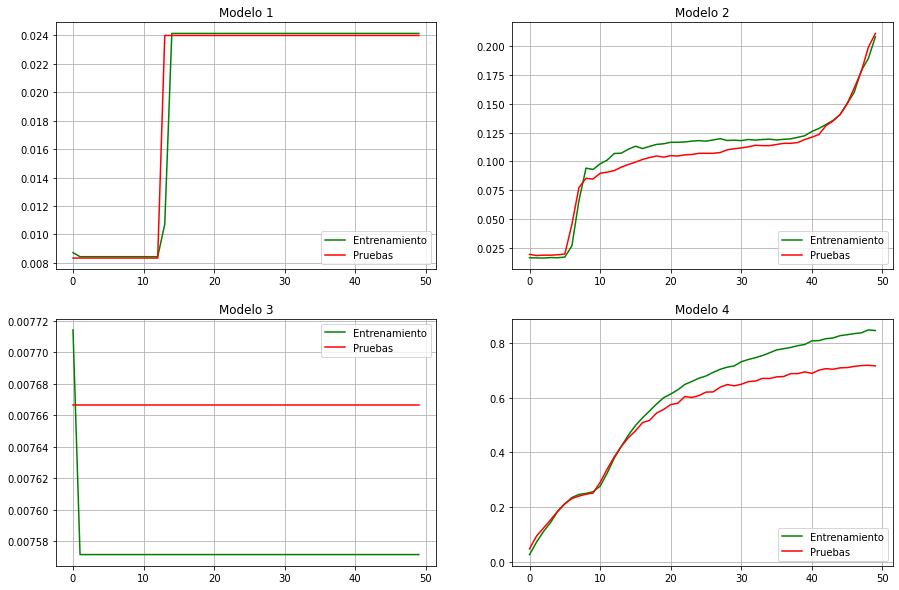

In [41]:
#Creamos el gráfico completo
grafico_a = pp.figure(figsize = (15, 10))

#Gráfico del modelo 1
parte1_a = grafico_a.add_subplot(2, 2, 1)
parte1_a.set_title('Modelo 1')
parte1_a.plot(historial1.history['accuracy'], color = 'green')
parte1_a.plot(historial1.history['val_accuracy'], color = 'red')
parte1_a.legend(['Entrenamiento', 'Pruebas'], loc = 'lower right')
parte1_a.grid(True)

#Gráfico del modelo 2
parte2_a = grafico_a.add_subplot(2, 2, 2)
parte2_a.set_title('Modelo 2')
parte2_a.plot(historial2.history['accuracy'], color = 'green')
parte2_a.plot(historial2.history['val_accuracy'], color = 'red')
parte2_a.legend(['Entrenamiento', 'Pruebas'], loc = 'lower right')
parte2_a.grid(True)

#Gráfico del modelo 3
parte3_a = grafico_a.add_subplot(2, 2, 3)
parte3_a.set_title('Modelo 3')
parte3_a.plot(historial3.history['accuracy'], color = 'green')
parte3_a.plot(historial3.history['val_accuracy'], color = 'red')
parte3_a.legend(['Entrenamiento', 'Pruebas'], loc = 'upper right')
parte3_a.grid(True)

#Gráfico del modelo 4
parte4_a = grafico_a.add_subplot(2, 2, 4)
parte4_a.set_title('Modelo 4')
parte4_a.plot(historial4.history['accuracy'], color = 'green')
parte4_a.plot(historial4.history['val_accuracy'], color = 'red')
parte4_a.legend(['Entrenamiento', 'Pruebas'], loc = 'lower right')
parte4_a.grid(True)

### 13. Grafica de pérdida Entrenamiento vs Pruebas

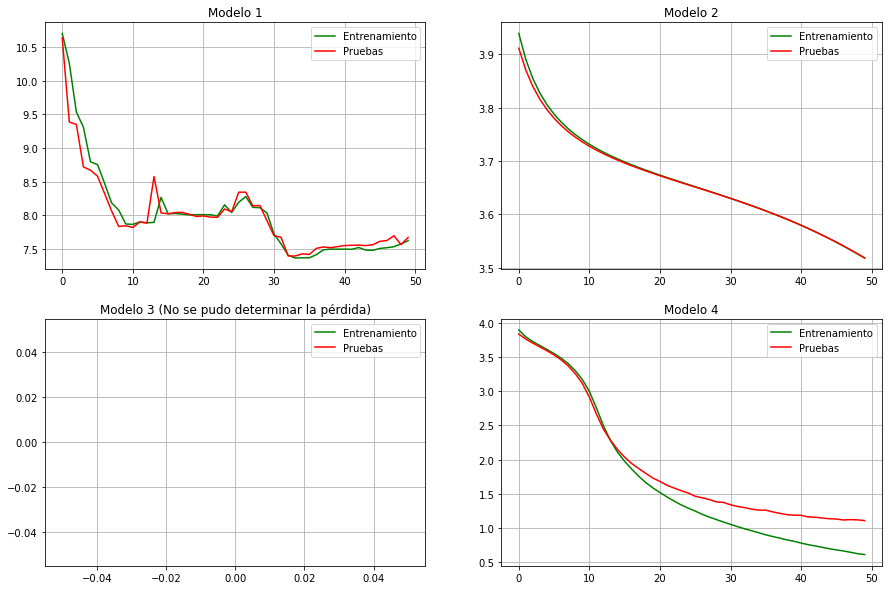

In [42]:
#Creamos el gráfico completo
grafico_b = pp.figure(figsize = (15, 10))

#Gráfico del modelo 1
parte1_b = grafico_b.add_subplot(2, 2, 1)
parte1_b.set_title('Modelo 1')
parte1_b.plot(historial1.history['loss'], color = 'green')
parte1_b.plot(historial1.history['val_loss'], color = 'red')
parte1_b.legend(['Entrenamiento', 'Pruebas'], loc = 'upper right')
parte1_b.grid(True)

#Gráfico del modelo 1
parte2_b = grafico_b.add_subplot(2, 2, 2)
parte2_b.set_title('Modelo 2')
parte2_b.plot(historial2.history['loss'], color = 'green')
parte2_b.plot(historial2.history['val_loss'], color = 'red')
parte2_b.legend(['Entrenamiento', 'Pruebas'], loc = 'upper right')
parte2_b.grid(True)

#Gráfico del modelo 1
parte3_b = grafico_b.add_subplot(2, 2, 3)
parte3_b.set_title('Modelo 3 (No se pudo determinar la pérdida)')
parte3_b.plot(historial3.history['loss'], color = 'green')
parte3_b.plot(historial3.history['val_loss'], color = 'red')
parte3_b.legend(['Entrenamiento', 'Pruebas'], loc = 'upper right')
parte3_b.grid(True)

#Gráfico del modelo 1
parte4_b = grafico_b.add_subplot(2, 2, 4)
parte4_b.set_title('Modelo 4')
parte4_b.plot(historial4.history['loss'], color = 'green')
parte4_b.plot(historial4.history['val_loss'], color = 'red')
parte4_b.legend(['Entrenamiento', 'Pruebas'], loc = 'upper right')
parte4_b.grid(True)

### 14. Matriz de confusión (Modelo 4)

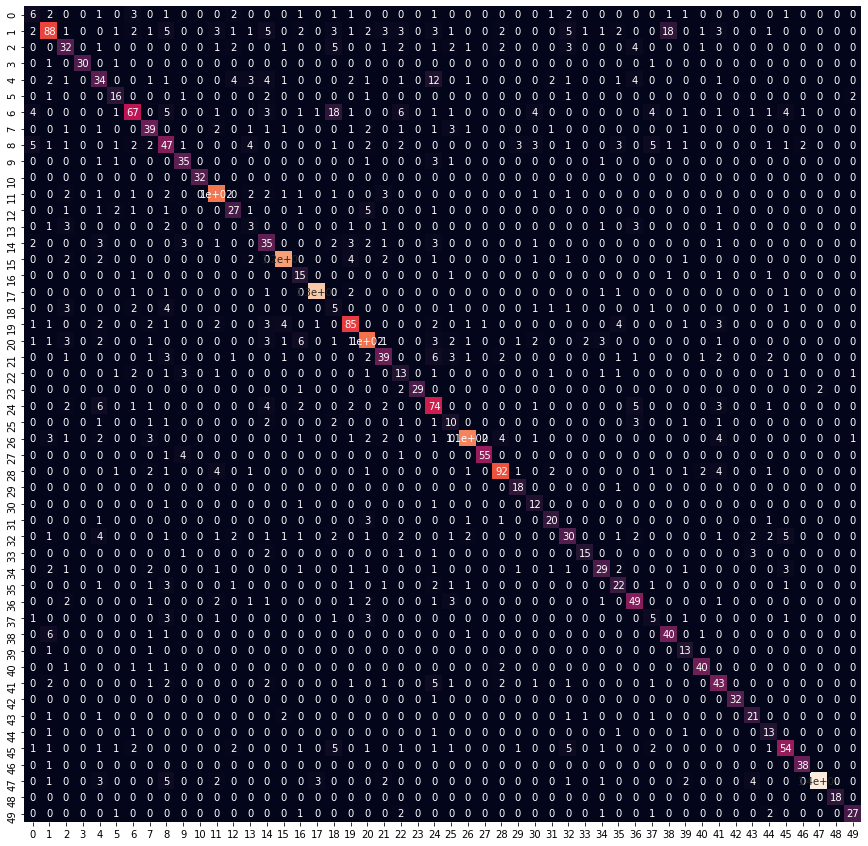

In [43]:
#Obtenemos la predicción para los datos de prueba
y_prediccion = modelo4_entrenado.predict(x_prueba)
y_prediccion = np.array(list(map(lambda m: [np.argmax(m)], y_prediccion)))

#Obtenemos la matriz de confusión
matriz_confusion = confusion_matrix(
    y_prediccion, 
    y_prueba,
)

#Graficamos la matriz
grafico_c = pp.figure(figsize = (15,15))
sb.heatmap(matriz_confusion, annot = True, cbar = False)
pp.show()

### 14. Guardando las imágenes del mejor modelo (Modelo 4)

In [44]:
#Guardando la gráfica de presición
filtro = parte4_a.get_window_extent().transformed(grafico_a.dpi_scale_trans.inverted())
grafico_a.savefig('Presicion.png', bbox_inches = filtro)

#Guardando la gráfica de pérdida
filtro = parte4_b.get_window_extent().transformed(grafico_b.dpi_scale_trans.inverted())
grafico_b.savefig('Perdida.png', bbox_inches = filtro)

#Guardando la mátriz de confusión
grafico_c.savefig('MatrizConfusion.png')

### 15. Guardando los resultados de entrenamiento en un reporte PDF

In [45]:
ancho, alto = A3

pdf = canvas.Canvas('Reporte.pdf', pagesize = A3)
pdf.drawString(30, alto - 50, 'Carlos Morocho, Wilson Rodas - Reporte de la RNA')
pdf.drawString(30, alto - 80, '1. Gráfico de presición')
pdf.drawImage('Presicion.png', 30, alto - 350)
pdf.drawString(30, alto - 390, '2. Gráfico de pérdida')
pdf.drawImage('Perdida.png', 30, alto - 660)
pdf.showPage()
pdf.drawString(30, alto - 50, '3. Matriz de confusión')
pdf.drawImage('MatrizConfusion.png', -110, alto - 1150)
pdf.showPage()
pdf.save()

### 16. Recuperando los datos de prueba para su uso

In [46]:
datos_prueba = pd.read_csv('imagenes-prueba.data', sep = ',')
datos_prueba

,0,1,2,3,4,5,6,7,8,9,...,3063,3064,3065,3066,3067,3068,3069,3070,3071,3072
0,255,255,255,255,254,242,222,217,222,242,...,226,218,226,245,254,255,255,255,255,3
1,255,255,255,255,255,255,255,255,255,252,...,255,255,255,255,255,255,255,255,255,11
2,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,14
3,255,255,255,255,255,255,255,255,255,254,...,25,25,25,25,25,25,25,25,40,35
4,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,19
2026,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,26
2027,255,255,255,255,255,255,255,255,255,255,...,220,221,224,233,247,254,255,255,255,28
2028,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,1


### 17. Seleccionando 20 imágenes de muestra al azar

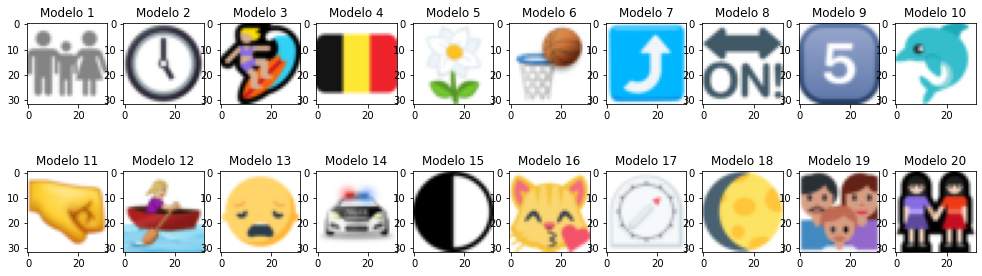

In [47]:
#Seleccionamos una muestra aleatoriamente
muestras = datos_prueba.sample(n = 20)

x = np.array(muestras.iloc[:, 0:3072])
y_verdadera = np.array(muestras.iloc[:, -1])

#Mostramos las imagenes
grafico = pp.figure(figsize = (17, 5))

i = 1
for imagen in x:
    #Gráfico del modelo 1
    parte = grafico.add_subplot(2, 10, i)
    parte.set_title('Modelo ' + str(i))
    
    #Convertimos el arreglo 1D a uno en 3D
    imagen = np.reshape(imagen, (-1, 32, 32))
    imagen = np.rollaxis(imagen, 0, 3)
    
    #Mostramos la imágen de ejemplo
    pp.imshow(imagen)
    i += 1

pp.show()

### 18. Prediciendo la imágen seleccionada

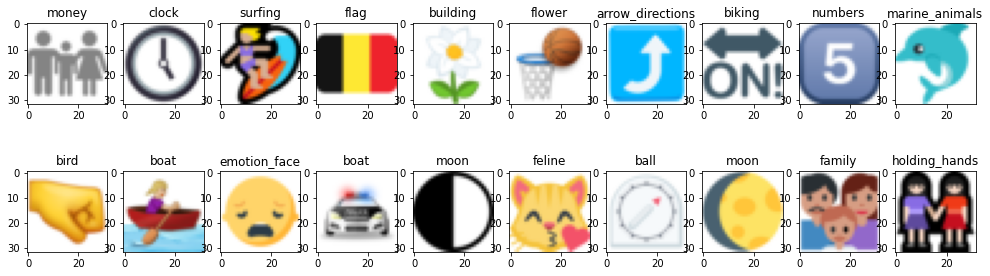

In [48]:
#Apartamos los datos de imagen sin transformar
imagenes = np.array(x)

#Escalamos la muestra
x = escalador.fit_transform(x)

#Realizamos la predicción
predicciones = modelo4_entrenado.predict(x)

y_prediccion = np.array(list(map(lambda m: [np.argmax(m)], predicciones)))

#Mostramos las imágenes y sus predicciones
grafico = pp.figure(figsize = (17, 5))

i = 1
for muestra in imagenes:
    #Gráfico del modelo 1
    parte = grafico.add_subplot(2, 10, i)
    parte.set_title(lista_categorias[int(y_prediccion[i - 1])])
    
    #Convertimos el arreglo 1D a uno en 3D
    muestra = np.reshape(muestra, (-1, 32, 32))
    muestra = np.rollaxis(muestra, 0, 3)

    #Mostramos la imágen de ejemplo
    pp.imshow(muestra)
    i += 1

pp.show()

### 19. Evaluando el modelo de prueba

In [50]:
#Evaluamos el modelo usando los datos de prueba
resultados = modelo4_entrenado.evaluate(x, y_verdadera, return_dict = True)
resultados

1/1 [==============================] - 0s 6ms/step - loss: 1.1606 - accuracy: 0.6500


{'loss': 1.1606336832046509, 'accuracy': 0.6499999761581421}

### 20. Gráfica de presición de la prueba

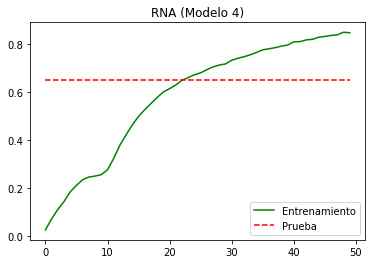

In [51]:
#Definimos el rango de valores
rango_x = range(0, 50)
rango_y = []
rango_y.extend(repeat(resultados['accuracy'], 50))

#Realizamos la gráfica
pp.title('RNA (Modelo 4)')
pp.plot(historial4.history['accuracy'], color = 'green')
pp.plot(rango_x, rango_y, linestyle = 'dashed',color = 'red')
pp.legend(['Entrenamiento', 'Prueba'], loc = 'lower right')
pp.savefig('Presicion-Prueba.png')
pp.show()

### 21. Gráfica de pérdida de la prueba

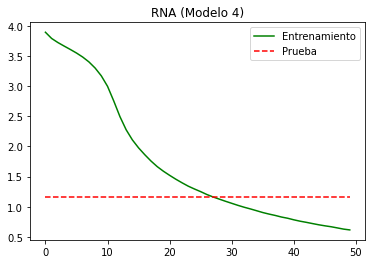

In [52]:
#Definimos el rango de valores
rango_x = range(0, 50)
rango_y = []
rango_y.extend(repeat(resultados['loss'], 50))

#Realizamos la gráfica
pp.title('RNA (Modelo 4)')
pp.plot(historial4.history['loss'], color = 'green')
pp.plot(rango_x, rango_y, linestyle = 'dashed',color = 'red')
pp.legend(['Entrenamiento', 'Prueba'], loc = 'upper right')
pp.savefig('Perdida-Prueba.png')
pp.show()

### 22. Matriz de confusión

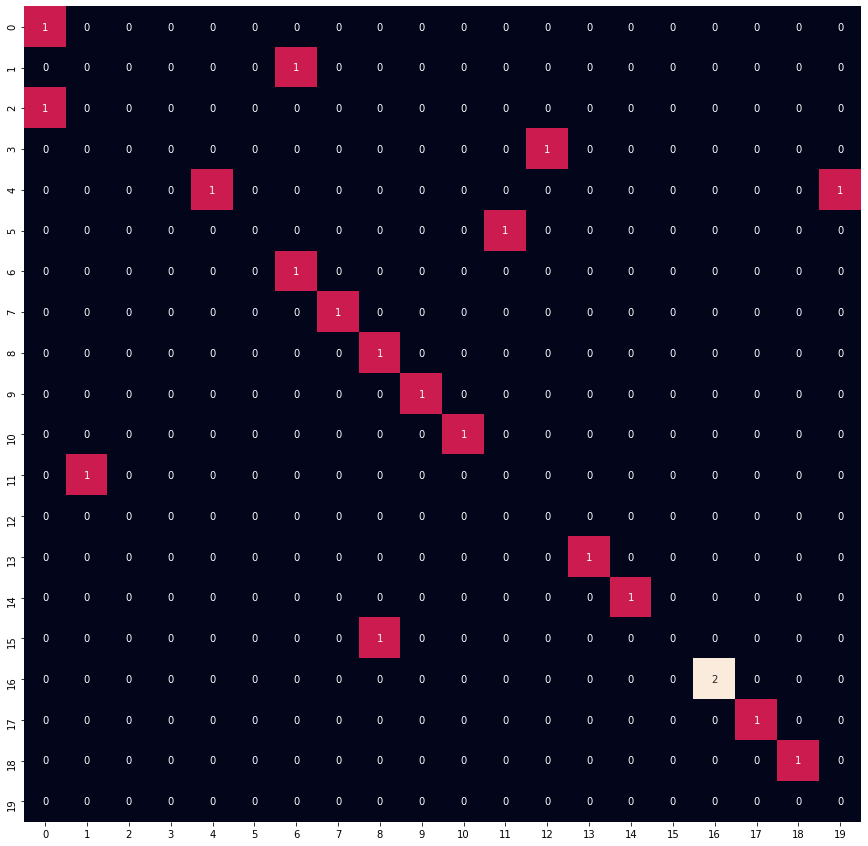

In [53]:
#Obtenemos la matriz de confusión
matriz_confusion = confusion_matrix(
    y_prediccion, 
    y_verdadera,
)

#Graficamos la matriz
grafico_c = pp.figure(figsize = (15,15))
sb.heatmap(matriz_confusion, annot = True, cbar = False)
grafico_c.savefig('MatrizConfusion-Prueba.png')
pp.show()

### 23. Guardando los resultados en un reporte

In [54]:
ancho, alto = A3

pdf = canvas.Canvas('ReportePrueba.pdf', pagesize = A3)
pdf.drawString(30, alto - 50, 'Carlos Morocho, Wilson Rodas - Reporte de prueba de la RNA')
pdf.drawString(30, alto - 80, '1. Gráfico de presición')
pdf.drawImage('Presicion-Prueba.png', 30, alto - 350)
pdf.drawString(30, alto - 390, '2. Gráfico de pérdida')
pdf.drawImage('Perdida-Prueba.png', 30, alto - 660)
pdf.showPage()
pdf.drawString(30, alto - 50, '3. Matriz de confusión')
pdf.drawImage('MatrizConfusion-Prueba.png', -110, alto - 1150)
pdf.showPage()
pdf.save()